In [3]:
import torch
from python_speech_features import mfcc, delta
import scipy.io.wavfile as wav
import numpy as np
import cPickle as pickle
from sklearn.cross_validation import train_test_split
from collections import Counter
from torch.autograd import Variable
from torch.utils.data import DataLoader
import xgboost
from sklearn.metrics import accuracy_score, f1_score
import lightgbm
import sys
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
%matplotlib inline

/home/sphere_4/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Preprocessing and feature extraction

In [270]:
train = []
for j in xrange(5):
    print 'Processing', 'good/train'+str(j+1)+'/train'+str(j+1)+'.wav'
    rate, sample = wav.read('good/train'+str(j+1)+'/train'+str(j+1)+'.wav')
#     sample = sample + np.random.randint(-100, 100, size=len(sample))
    tmp = []
    for i in xrange(n_batches):
        tmp.append(mfcc(sample[i*len(sample)/n_batches:(i+1)*len(sample)/n_batches], samplerate=rate))
    mfcc_feat = np.vstack(tmp)
    train.append(mfcc_feat)
    
    with open('train/train'+str(i+1)+'_mfcc_bin', 'w') as f:
        pickle.dump(mfcc_feat, f)
        f.close()

Processing good/train1/train1.wav
Processing good/train2/train2.wav
Processing good/train3/train3.wav
Processing good/train4/train4.wav
Processing good/train5/train5.wav


In [271]:
total_size = sum(train[i].shape[0] for i in xrange(5))

In [272]:
total_size

18803120

In [273]:
for x in train:
    print x.shape

(744490, 13)
(2356100, 13)
(5062340, 13)
(8658390, 13)
(1981800, 13)


In [274]:
X_data = np.zeros((744490*5, 39))
y_data = np.zeros(744490*5)

Обеспечим баланс классов на трейне, взяв для каждого диктора одинаковое число семплов

In [275]:
k = 0
for i, x in enumerate(train):
    x = x[:744490]
    d = delta(x, 2)
    dd = delta(d, 2)
    X_data[k:k+len(x)] = np.hstack([x, d, dd])
    y_data[k:k+len(x)] = i
    k += len(x)

In [317]:
# np.savez('good/train_dataset_bin', X_data=X_data, y_data=y_data)

In [4]:
data = np.load('good/train_dataset_bin.npz')

In [5]:
X_data = data['X_data']

In [6]:
y_data = data['y_data']

In [7]:
del data

In [7]:
Counter(y_data)

Counter({0.0: 744490, 1.0: 744490, 2.0: 744490, 3.0: 744490, 4.0: 744490})

## Baseline with lightgbm

In [277]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3)

In [278]:
Counter(y_train)

Counter({0.0: 521155, 1.0: 520949, 2.0: 521432, 3.0: 520701, 4.0: 521478})

In [279]:
lgb = lightgbm.LGBMClassifier(n_estimators=500, n_jobs=32, silent=False, max_depth=4)

In [280]:
lgb.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', colsample_bytree=1.0, learning_rate=0.1,
        max_bin=255, max_depth=4, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=500,
        n_jobs=32, num_leaves=31, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, silent=False, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=1)

In [298]:
pred = lgb.predict(X_test)

In [299]:
accuracy_score(y_test, pred)

0.85452770800592803

In [300]:
f1_score(y_test, pred, average='weighted')

0.85401977367310589

### Test on books that not in train set 

In [286]:
test = [np.zeros(0)]*5
for j in xrange(5):
    print 'Processing', 'good/val'+str(j+1)+'/train'+str(j+1)+'.wav'
    rate, sample = wav.read('good/val'+str(j+1)+'/train'+str(j+1)+'.wav')
    tmp = []
    for i in xrange(n_batches):
        tmp.append(mfcc(sample[i*len(sample)/n_batches:(i+1)*len(sample)/n_batches], samplerate=rate))
    mfcc_feat = np.vstack(tmp)
    test[j] = mfcc_feat
    
#     with open('train/train'+str(i+1)+'_mfcc_bin', 'w') as f:
#         pickle.dump(mfcc_feat, f)
#         f.close()

Processing good/val1/train1.wav
Processing good/val2/train2.wav
Processing good/val3/train3.wav
Processing good/val4/train4.wav
Processing good/val5/train5.wav


In [287]:
total_size = sum(test[i].shape[0] for i in xrange(5))

In [288]:
for x in test:
    print x.shape

(326810, 13)
(2174940, 13)
(3129180, 13)
(6634410, 13)
(8113340, 13)


In [289]:
total_size

20378680

In [290]:
test[2]

array([[ -3.60436534e+01,   0.00000000e+00,  -3.20763172e-14, ...,
         -3.27769755e-13,   0.00000000e+00,   3.59484803e-13],
       [ -3.60436534e+01,   0.00000000e+00,  -3.20763172e-14, ...,
         -3.27769755e-13,   0.00000000e+00,   3.59484803e-13],
       [  1.06991813e+00,  -4.32328774e+01,  -1.42820491e+01, ...,
         -7.96303956e+00,  -3.01999593e+00,  -1.03620563e+00],
       ..., 
       [  1.06991813e+00,  -3.68103113e+01,  -1.01966264e+01, ...,
         -2.93501126e+00,  -4.03316662e+00,  -4.97764955e+00],
       [ -2.60967571e-02,  -3.67204120e+01,  -1.04430984e+01, ...,
         -3.09882535e+00,  -3.06803336e+00,  -2.49297349e+00],
       [ -2.60967571e-02,  -3.67204120e+01,  -1.04430984e+01, ...,
         -3.09882535e+00,  -3.06803336e+00,  -2.49297349e+00]])

In [291]:
X_data_test = np.zeros((total_size, 39))
y_data_test = np.zeros(total_size)

In [292]:
k = 0
for i, x in enumerate(test):
    if len(x) > 0:
        d = delta(x, 2)
        dd = delta(d, 2)
        X_data_test[k:k+len(x)] = np.hstack([x, d, dd])
        y_data_test[k:k+len(x)] = i
        k += len(x)

In [316]:
# np.savez('good/test_dataset_bin', X_data=X_data_test, y_data=y_data_test)

In [8]:
data = np.load('good/test_dataset_bin.npz')
X_data_test = data['X_data']
y_data_test = data['y_data']

In [9]:
del data

In [293]:
pred = lgb.predict(X_data_test)

In [294]:
Counter(pred)

Counter({0.0: 1325447, 1.0: 1947809, 2.0: 3684686, 3.0: 6686740, 4.0: 6733998})

In [297]:
f1_score(y_data_test, pred, average='weighted')

0.76338370801899957

In [296]:
accuracy_score(y_data_test, pred)

0.75022813057568005

### Making dataset for RNN

Создадим датасет следующим образом: одним наблюдением будем считать 10к подряд идущих окон для определенного диктора (~4 мин). Возьмем по 500 наблюдений для каждого диктора.

In [11]:
seq_len = 500

In [12]:
train_X_data_np = np.zeros((seq_len*5, 10000, 39), dtype=float)
train_y_data_np = np.zeros((seq_len*5, 10000), dtype=float)

In [13]:
k = 0
for i in xrange(5):
    x = X_data[y_data == i]
    y = i
    
    indices = np.random.choice(xrange(len(x) - 10000), size=seq_len, replace=False)
    for j in xrange(seq_len):
        train_X_data_np[k] = x[indices[j]:indices[j] + 10000]
        train_y_data_np[k] = y
        k += 1

In [14]:
test_X_data_np = np.zeros((seq_len*5, 10000, 39), dtype=float)
test_y_data_np = np.zeros((seq_len*5, 10000), dtype=float)

In [15]:
k = 0
for i in xrange(5):
    x = X_data_test[y_data_test == i]
    y = i
    
    indices = np.random.choice(xrange(len(x) - 10000), size=seq_len, replace=False)
    for j in xrange(seq_len):
        test_X_data_np[k] = x[indices[j]:indices[j] + 10000]
        test_y_data_np[k] = y
        k += 1

## Bidirectional LSTM

In [63]:
n_layers = 3
h_size = 25
inp_size = 39
n_class = 5

In [64]:
dtype = torch.FloatTensor
losses = []
tmp_loss = []
test_loss = []
lstm = torch.nn.LSTM(input_size=inp_size, hidden_size=h_size, num_layers=n_layers,
                     bidirectional=True, batch_first=True).cuda()

model = torch.nn.Sequential(torch.nn.ReLU(), torch.nn.Dropout(), torch.nn.Linear(2*h_size, n_class), torch.nn.Softmax()).cuda()

loss_fn = torch.nn.NLLLoss().cuda()

learning_rate = 0.0005
optimizer = torch.optim.Adam(list(lstm.parameters())+list(model.parameters()), lr=learning_rate)

train_data = torch.utils.data.TensorDataset(torch.from_numpy(train_X_data_np).type(dtype),
                                            torch.from_numpy(train_y_data_np).type(torch.LongTensor))
test_data = torch.utils.data.TensorDataset(torch.from_numpy(test_X_data_np).type(dtype),
                                           torch.from_numpy(test_y_data_np).type(torch.LongTensor))

train_loader = DataLoader(train_data, batch_size=10, shuffle=True, num_workers=31)
test_loader = DataLoader(test_data, batch_size=10, shuffle=True, num_workers=31)

scheduler = ReduceLROnPlateau(optimizer=optimizer, factor=0.95, min_lr=0.0001, patience=50)

In [73]:
optimizer.param_groups[0]['lr'] = 0.0001

In [ ]:
for epoch in range(5):
    for i, (x, y) in enumerate(train_loader):

        x = x.cuda()
        y = y.cuda()
        x = Variable(x)
        y = Variable(y)
        y_pred, _ = lstm(x)

        y_pred = model(y_pred[:,-1])
        y = y[:,-1]

        loss = loss_fn(y_pred, y)
        tmp_loss.append(loss.data[0])
        
#         scheduler.step(loss.data[0])

        optimizer.zero_grad()

        loss.backward()
        
        optimizer.step()
        
        if i%5 == 0:
            losses.append(np.mean(tmp_loss))
            tmp_loss = []
            f1_scores = []
            y1 = []
            y2 = []
            for j, (x_t, y_t) in enumerate(test_loader):
                
                x_t = x_t.cuda()
                y_t = y_t.cuda()
                x_t = Variable(x_t)
                y_t = Variable(y_t)
                y_pred, _ = lstm(x_t)

                y_pred = model(y_pred[:,-1])
                y_t = y_t[:,-1]
                y1.append(y_t.data.cpu().numpy())
                y2.append(np.argmax(y_pred.data.cpu().numpy(), axis=1))
                
                loss = loss_fn(y_pred, y_t)
                test_loss.append(loss.data[0])
                if j > 5:
                    break
                    
            sys.stdout.write("\rEpoch "+str(epoch)+", Itteration "+str(i)+", train loss = "+str(losses[-1])+
                             ", test loss = "+str(test_loss[-1])+" ,f1_score = "
                             +str(f1_score(np.hstack(y1), np.hstack(y2), average='weighted'))+
                             " ,lr: "+str(optimizer.param_groups[0]['lr'])+'\t\t\t')

Epoch 2, Itteration 70, train loss = -0.786568820477, test loss = -0.601949930191 ,f1_score = 0.666010777071 ,lr: 0.0001				

In [75]:
optimizer.param_groups[0]['lr']

0.0001

In [76]:
losses[-1]

-0.78328535556793211

In [77]:
test_loss[-1]

-0.9026975631713867

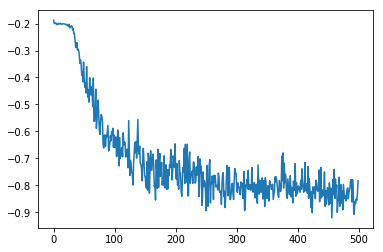

In [78]:
plt.plot(losses)

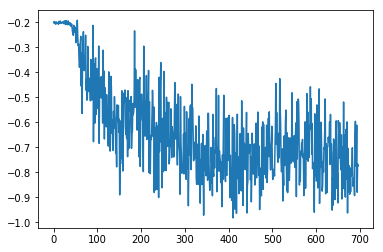

In [110]:
plt.plot(test_loss[:-100:5])

In [82]:
torch.save(model, 'trained_clf3_3')
torch.save(lstm, 'trained_lstm3_3')

In [83]:
model = torch.load('trained_clf3_3')
lstm = torch.load('trained_lstm3_3')

In [84]:
y1 = []
y2 = []
for j, (x_t, y_t) in enumerate(test_loader):

    x_t = x_t.cuda()
    y_t = y_t.cuda()
    x_t = Variable(x_t)
    y_t = Variable(y_t)
    y_pred, _ = lstm(x_t)

    y_pred = model(y_pred[:,-1])
    y_t = y_t[:,-1]
    y1.append(y_t.data.cpu().numpy())
    y2.append(np.argmax(y_pred.data.cpu().numpy(), axis=1))

    loss = loss_fn(y_pred, y_t)

/home/sphere_4/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greately increasing memory usage. To compact weights again call flatten_parameters().
  if __name__ == '__main__':


In [85]:
f1_score(np.hstack(y1), np.hstack(y2), average='weighted')

0.83622295773508071

### Trying transfer learning

In [92]:
model = torch.nn.Sequential(torch.nn.ReLU(), torch.nn.Dropout(), torch.nn.Linear(2*h_size, n_class), torch.nn.Softmax()).cuda()
loss_fn = torch.nn.NLLLoss().cuda()

learning_rate = 0.0005
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [93]:
losses1 = []
test_loss1 = []

In [94]:
lstm.flatten_parameters()

In [98]:
optimizer.param_groups[0]['lr'] = 0.0001

In [ ]:
for epoch in range(5):
    for i, (x, y) in enumerate(train_loader):

        x = x.cuda()
        y = y.cuda()
        x = Variable(x)
        y = Variable(y)
        y_pred, _ = lstm(x)

        y_pred = model(y_pred[:,-1])
        y = y[:,-1]

        loss = loss_fn(y_pred, y)
        tmp_loss.append(loss.data[0])
        
#         scheduler.step(loss.data[0])

        optimizer.zero_grad()

        loss.backward()
        
        optimizer.step()
        
        if i%5 == 0:
            losses1.append(np.mean(tmp_loss))
            tmp_loss = []
            f1_scores = []
            y1 = []
            y2 = []
            for j, (x_t, y_t) in enumerate(test_loader):
                
                x_t = x_t.cuda()
                y_t = y_t.cuda()
                x_t = Variable(x_t)
                y_t = Variable(y_t)
                y_pred, _ = lstm(x_t)

                y_pred = model(y_pred[:,-1])
                y_t = y_t[:,-1]
                y1.append(y_t.data.cpu().numpy())
                y2.append(np.argmax(y_pred.data.cpu().numpy(), axis=1))
                
                loss = loss_fn(y_pred, y_t)
                test_loss1.append(loss.data[0])
                if j > 5:
                    break
                    
            sys.stdout.write("\rEpoch "+str(epoch)+", Itteration "+str(i)+", train loss = "+str(losses1[-1])+
                             ", test loss = "+str(test_loss1[-1])+" ,f1_score = "
                             +str(f1_score(np.hstack(y1), np.hstack(y2), average='weighted'))+
                             " ,lr: "+str(optimizer.param_groups[0]['lr'])+'\t\t\t')

Epoch 2, Itteration 5, train loss = -0.900715017319, test loss = -0.68762165308 ,f1_score = 0.803090854543 ,lr: 0.0001						

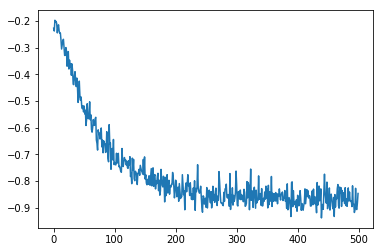

In [100]:
plt.plot(losses1)

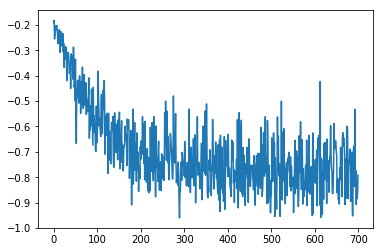

In [106]:
plt.plot(test_loss1[::5])

In [102]:
y1 = []
y2 = []
for j, (x_t, y_t) in enumerate(test_loader):

    x_t = x_t.cuda()
    y_t = y_t.cuda()
    x_t = Variable(x_t)
    y_t = Variable(y_t)
    y_pred, _ = lstm(x_t)

    y_pred = model(y_pred[:,-1])
    y_t = y_t[:,-1]
    y1.append(y_t.data.cpu().numpy())
    y2.append(np.argmax(y_pred.data.cpu().numpy(), axis=1))

    loss = loss_fn(y_pred, y_t)

In [103]:
f1_score(np.hstack(y1), np.hstack(y2), average='weighted')

0.84443346669694219

In [105]:
torch.save(model, 'trained_clf4_3')

Получили еще +1% к качеству.

### Try train LSTM with dropout

In [118]:
dtype = torch.FloatTensor
losses2 = []
tmp_loss = []
test_loss2 = []
lstm = torch.nn.LSTM(input_size=inp_size, hidden_size=h_size, num_layers=n_layers,
                     bidirectional=True, batch_first=True, dropout=True).cuda()

model = torch.nn.Sequential(torch.nn.ReLU(), torch.nn.Dropout(), torch.nn.Linear(2*h_size, n_class), torch.nn.Softmax()).cuda()

loss_fn = torch.nn.NLLLoss().cuda()

learning_rate = 0.05
optimizer = torch.optim.Adam(list(lstm.parameters())+list(model.parameters()), lr=learning_rate)

In [119]:
for epoch in range(5):
    for i, (x, y) in enumerate(train_loader):

        x = x.cuda()
        y = y.cuda()
        x = Variable(x)
        y = Variable(y)
        y_pred, _ = lstm(x)

        y_pred = model(y_pred[:,-1])
        y = y[:,-1]

        loss = loss_fn(y_pred, y)
        tmp_loss.append(loss.data[0])
        
#         scheduler.step(loss.data[0])

        optimizer.zero_grad()

        loss.backward()
        
        optimizer.step()
        
        if i%5 == 0:
            losses2.append(np.mean(tmp_loss))
            tmp_loss = []
            f1_scores = []
            y1 = []
            y2 = []
            for j, (x_t, y_t) in enumerate(test_loader):
                
                x_t = x_t.cuda()
                y_t = y_t.cuda()
                x_t = Variable(x_t)
                y_t = Variable(y_t)
                y_pred, _ = lstm(x_t)

                y_pred = model(y_pred[:,-1])
                y_t = y_t[:,-1]
                y1.append(y_t.data.cpu().numpy())
                y2.append(np.argmax(y_pred.data.cpu().numpy(), axis=1))
                
                loss = loss_fn(y_pred, y_t)
                tmp_loss.append(loss.data[0])
                if j > 5:
                    test_loss2.append(np.mean(tmp_loss))
                    tmp_loss = []
                    break
                    
            sys.stdout.write("\rEpoch "+str(epoch)+", Itteration "+str(i)+", train loss = "+str(losses2[-1])+
                             ", test loss = "+str(test_loss2[-1])+" ,f1_score = "
                             +str(f1_score(np.hstack(y1), np.hstack(y2), average='weighted'))+
                             " ,lr: "+str(optimizer.param_groups[0]['lr'])+'\t\t\t')

Epoch 4, Itteration 245, train loss = -0.193217757344, test loss = -0.252383127809 ,f1_score = 0.162328042328 ,lr: 0.05				

Сходимости к сожалению не удалось добиться даже при довольно больших темпах обучения.

### Try GRU

In [120]:
n_layers = 3
h_size = 25
inp_size = 39
n_class = 5

In [125]:
dtype = torch.FloatTensor
losses3 = []
tmp_loss = []
test_loss3 = []
lstm = torch.nn.GRU(input_size=inp_size, hidden_size=h_size, num_layers=n_layers,
                     bidirectional=True, batch_first=True).cuda()

model = torch.nn.Sequential(torch.nn.ReLU(), torch.nn.Dropout(), torch.nn.Linear(2*h_size, n_class), torch.nn.Softmax()).cuda()

loss_fn = torch.nn.NLLLoss().cuda()

learning_rate = 0.001
optimizer = torch.optim.Adam(list(lstm.parameters())+list(model.parameters()), lr=learning_rate)

In [126]:
for epoch in range(5):
    for i, (x, y) in enumerate(train_loader):

        x = x.cuda()
        y = y.cuda()
        x = Variable(x)
        y = Variable(y)
        y_pred, _ = lstm(x)

        y_pred = model(y_pred[:,-1])
        y = y[:,-1]

        loss = loss_fn(y_pred, y)
        tmp_loss.append(loss.data[0])

        optimizer.zero_grad()

        loss.backward()
        
        optimizer.step()
        
        if i%5 == 0:
            losses3.append(np.mean(tmp_loss))
            tmp_loss = []
            f1_scores = []
            y1 = []
            y2 = []
            for j, (x_t, y_t) in enumerate(test_loader):
                
                x_t = x_t.cuda()
                y_t = y_t.cuda()
                x_t = Variable(x_t)
                y_t = Variable(y_t)
                y_pred, _ = lstm(x_t)

                y_pred = model(y_pred[:,-1])
                y_t = y_t[:,-1]
                y1.append(y_t.data.cpu().numpy())
                y2.append(np.argmax(y_pred.data.cpu().numpy(), axis=1))
                
                loss = loss_fn(y_pred, y_t)
                tmp_loss.append(loss.data[0])
                if j > 5:
                    test_loss3.append(np.mean(tmp_loss))
                    tmp_loss = []
                    break
                    
            sys.stdout.write("\rEpoch "+str(epoch)+", Itteration "+str(i)+", train loss = "+str(losses3[-1])+
                             ", test loss = "+str(test_loss3[-1])+" ,f1_score = "
                             +str(f1_score(np.hstack(y1), np.hstack(y2), average='weighted'))+
                             " ,lr: "+str(optimizer.param_groups[0]['lr'])+'\t\t\t')

Epoch 4, Itteration 245, train loss = -0.983264756203, test loss = -0.810945681163 ,f1_score = 0.787527472527 ,lr: 0.001			

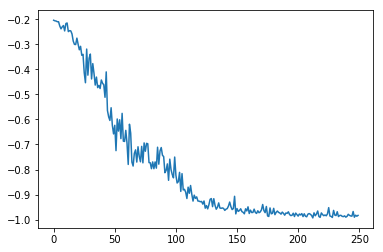

In [127]:
plt.plot(losses3)

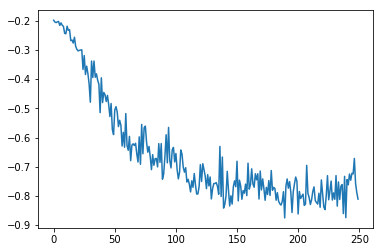

In [128]:
plt.plot(test_loss3)

In [129]:
y1 = []
y2 = []
for j, (x_t, y_t) in enumerate(test_loader):

    x_t = x_t.cuda()
    y_t = y_t.cuda()
    x_t = Variable(x_t)
    y_t = Variable(y_t)
    y_pred, _ = lstm(x_t)

    y_pred = model(y_pred[:,-1])
    y_t = y_t[:,-1]
    y1.append(y_t.data.cpu().numpy())
    y2.append(np.argmax(y_pred.data.cpu().numpy(), axis=1))

    loss = loss_fn(y_pred, y_t)

In [130]:
f1_score(np.hstack(y1), np.hstack(y2), average='weighted')

0.75087564554026054

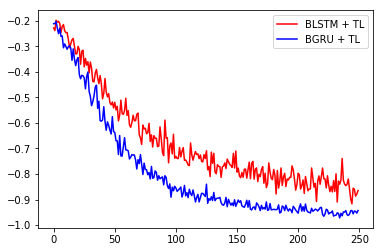

In [141]:
plt.plot(losses1[:250], c='r', label='BLSTM + TL')
plt.plot(losses4, c='b', label='BGRU + TL')
plt.legend()

### Transfer  learning for GRU

In [131]:
losses4 = []
tmp_loss = []
test_loss4 = []
model = torch.nn.Sequential(torch.nn.ReLU(), torch.nn.Dropout(), torch.nn.Linear(2*h_size, n_class), torch.nn.Softmax()).cuda()
loss_fn = torch.nn.NLLLoss().cuda()

learning_rate = 0.0005
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
for epoch in range(5):
    for i, (x, y) in enumerate(train_loader):

        x = x.cuda()
        y = y.cuda()
        x = Variable(x)
        y = Variable(y)
        y_pred, _ = lstm(x)

        y_pred = model(y_pred[:,-1])
        y = y[:,-1]

        loss = loss_fn(y_pred, y)
        tmp_loss.append(loss.data[0])

        optimizer.zero_grad()

        loss.backward()
        
        optimizer.step()
        
        if i%5 == 0:
            losses4.append(np.mean(tmp_loss))
            tmp_loss = []
            f1_scores = []
            y1 = []
            y2 = []
            for j, (x_t, y_t) in enumerate(test_loader):
                
                x_t = x_t.cuda()
                y_t = y_t.cuda()
                x_t = Variable(x_t)
                y_t = Variable(y_t)
                y_pred, _ = lstm(x_t)

                y_pred = model(y_pred[:,-1])
                y_t = y_t[:,-1]
                y1.append(y_t.data.cpu().numpy())
                y2.append(np.argmax(y_pred.data.cpu().numpy(), axis=1))
                
                loss = loss_fn(y_pred, y_t)
                tmp_loss.append(loss.data[0])
                if j > 5:
                    test_loss4.append(np.mean(tmp_loss))
                    tmp_loss = []
                    break
                    
            sys.stdout.write("\rEpoch "+str(epoch)+", Itteration "+str(i)+", train loss = "+str(losses4[-1])+
                             ", test loss = "+str(test_loss4[-1])+" ,f1_score = "
                             +str(f1_score(np.hstack(y1), np.hstack(y2), average='weighted'))+
                             " ,lr: "+str(optimizer.param_groups[0]['lr'])+'\t\t\t')

Epoch 3, Itteration 50, train loss = -0.903518331051, test loss = -0.736119372504 ,f1_score = 0.791833230708 ,lr: 0.0005				

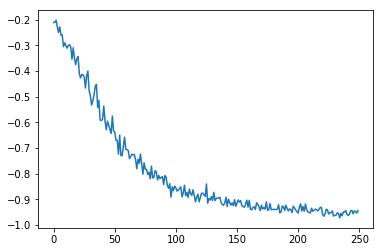

In [133]:
plt.plot(losses4)

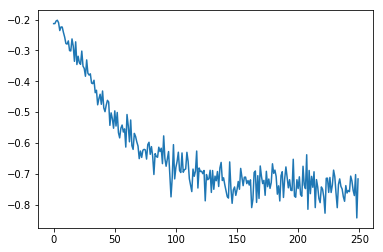

In [134]:
plt.plot(test_loss4)

In [135]:
y1 = []
y2 = []
for j, (x_t, y_t) in enumerate(test_loader):

    x_t = x_t.cuda()
    y_t = y_t.cuda()
    x_t = Variable(x_t)
    y_t = Variable(y_t)
    y_pred, _ = lstm(x_t)

    y_pred = model(y_pred[:,-1])
    y_t = y_t[:,-1]
    y1.append(y_t.data.cpu().numpy())
    y2.append(np.argmax(y_pred.data.cpu().numpy(), axis=1))

    loss = loss_fn(y_pred, y_t)

In [136]:
f1_score(np.hstack(y1), np.hstack(y2), average='weighted')

0.74779447995105508

:(